# Quads design (3dp pla + blue shims) for energy focusing with single target region


## Imports


NOTE: Please download data associated to this repository from https://doi.org/10.5281/zenodo.12823471


In [1]:
from difflexmm.utils import save_data, load_data
from difflexmm.geometry import QuadGeometry, compute_inertia
from difflexmm.plotting import generate_animation, plot_geometry
from problems.quads_focusing import ForwardProblem
from problems.quads_focusing_multi_input import OptimizationProblem
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any, Optional

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Plotting functions

In [2]:
def plot_objective_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 10)):
    n_problem = len(optimization.forward_problems)

    fig, axes = plt.subplots(
        nrows=3+n_problem, figsize=figsize, sharex=True, constrained_layout=True)
    axes[0].set(ylabel="Objective")
    axes[0].plot(optimization.objective_values, lw=3, color="#2980b9")
    for i in range(n_problem):
        axes[i+1].set(ylabel=f"Objective {i+1}")
        axes[i+1].plot(jnp.array(optimization.objective_values_individual)
                       [:, i], lw=3, color="#2980b9")
    axes[-2].set(ylabel="Angle constraints violation")
    axes[-2].plot(optimization.constraints_violation["angles"],
                  lw=3, color="#c0392b")
    axes[-1].set(ylabel="Edge length constraints violation")
    axes[-1].plot(optimization.constraints_violation["edge_lengths"],
                  lw=3, color="#c0392b")
    axes[-1].set(xlabel="Iteration")
    for ax in axes:
        ax.axhline(y=0, color="black", lw=1)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def generate_response_animations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, **plot_kwargs):

    for problem in optimization.forward_problems:
        if not problem.is_setup:
            problem.setup()
        if problem.solution_data is None:
            solution = problem.solve(optimization.design_values[-1])
        else:
            solution = problem.solution_data
        label = problem.loaded_side
        xlim, ylim = problem.geometry.get_xy_limits(
            *optimization.design_values[-1]) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])

        generate_animation(
            data=solution,
            field="v",
            out_filename=f"../out/{optimization.name}/{optimization_filename}/loaded_{label}",
            deformed=True,
            xlim=xlim,
            ylim=ylim,
            **plot_kwargs
        )
        print(f"Generated animation for {label} side")


def kinetic_energy_per_block(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def average_kinetic_energy_per_block(solution_data, blocks_inertia):
    return jnp.sum(
        kinetic_energy_per_block(
            solution_data.fields[:, 1],
            blocks_inertia,
        )/solution_data.timepoints.shape[0],
        axis=0,
    )


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, design_label: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True, field_values=None, cmap: Any = "inferno", vmin=None, vmax=None, color=None, cmap_label=None, scaling=1., deformed=False, block_displacements=None):

    if not optimization.forward_problems[0].is_setup:
        optimization.forward_problems[0].setup()

    xlim, ylim = optimization.forward_problems[0].geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problems[0].spacing * jnp.array([[-1., 1.], [-0.5, 0.5]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problems[0].geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problems[0].geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problems[0].geometry.bond_connectivity(),
        deformed=deformed,
        block_displacements=block_displacements,
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    if field_values is not None and color is None:
        axes.collections[0].set_array(field_values)
        axes.collections[0].set_cmap(cmap)
        axes.collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling,
                vmin=jnp.min(field_values) if vmin is None else vmin,
                vmax=jnp.max(field_values) if vmax is None else vmax,
            )
        )
        cb = fig.colorbar(axes.collections[0], ax=axes, pad=0.01, aspect=25)
        cb.ax.tick_params(
            labelsize=0.8*fontsize if fontsize is not None else None)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    if optimization_filename is not None:
        _design_label = f"design_{iteration_label:03d}_{design_label}" if design_label is not None else f"design_{iteration_label:03d}"
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/{_design_label}.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)

    return fig, axes

## Optimal design and response


In [3]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 16
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
# horizontal_shifts = jnp.zeros((n1_blocks+1, n2_blocks, 2))  # Initial design
# vertical_shifts = jnp.zeros((n1_blocks, n2_blocks+1, 2))  # Initial design
initial_angle = 25*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Loading params
amplitude = 0.5 * spacing
loading_rate = 30.  # Hz loading frequency
# 3 different loading locations
loaded_sides = ["left", "right", "bottom"]
input_shifts = [0, -2, -4]
n_excited_blocks = [2, 2, 2]
problems = [
    ForwardProblem(
        # Geometrical params
        n1_blocks=n1_blocks,
        n2_blocks=n2_blocks,
        spacing=spacing,
        bond_length=hinge_length,
        # Mechanical params
        k_stretch=k_stretch,
        k_shear=k_shear,
        k_rot=k_rot,
        density=density,
        damping=damping,
        use_contact=True,
        k_contact=k_rot,
        min_angle=-15*jnp.pi/180,
        cutoff_angle=-10*jnp.pi/180,
        # Dynamic loading
        amplitude=amplitude,
        loading_rate=loading_rate,
        input_delay=0.1*loading_rate**-1,
        n_excited_blocks=n_excited,
        loaded_side=loaded_side,
        input_shift=input_shift,
        # Analysis params
        simulation_time=2*loading_rate**-1,  # s
        n_timepoints=200,
        # Solver tolerances
        atol=1e-4,
        # Problem name (folder name)
        name="quads_focusing_multi_input_3dp_pla_shims",
    )
    for loaded_side, input_shift, n_excited in zip(loaded_sides, input_shifts, n_excited_blocks)]

# Optimization problem
target_size = (2, 2)
target_shift = (4, 5)
# (Focusing, Focusing, Focusing)
weights = jnp.ones(len(problems))/len(problems)
optimization = OptimizationProblem(
    forward_problems=problems,
    target_size=target_size,
    target_shift=target_shift,
    weights=weights,
    name="quads_focusing_multi_input_3dp_pla_shims",
)

problem_filename_prefix = f"quads{'_linearized_strains' if optimization.forward_problems[0].linearized_strains else ''}_{optimization.forward_problems[0].n1_blocks}x{optimization.forward_problems[0].n2_blocks}_amplitude_{optimization.forward_problems[0].amplitude:.2f}_loading_rate_{optimization.forward_problems[0].loading_rate:.2f}_initial_angle_{initial_angle*180/jnp.pi:.1f}_loaded_sides_{[p.loaded_side for p in optimization.forward_problems]}_excited_blocks_{optimization.forward_problems[0].n_excited_blocks}_input_shift_{[p.input_shift for p in optimization.forward_problems]}"
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename_prefix}_target_size_{optimization.target_size}_target_shifts_{optimization.target_shift}"

### Import most recent optimization object


In [4]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
# optimization.run_optimization_nlopt(
#     # initial_guess=(horizontal_shifts, vertical_shifts),
#     initial_guess=optimization.design_values[-1],
#     n_iterations=40,
#     min_block_angle=30*jnp.pi/180,
#     min_void_angle=0*jnp.pi/180,
#     min_edge_length=3.,  # mm
#     max_time=8*60*60,  # 8 hour
#     # lower_bound=-0.22*optimization.forward_problem.spacing,
#     # upper_bound=0.22*optimization.forward_problem.spacing,
# )

# save_data(
#     f"../data/{optimization.name}/{optimization_filename}.pkl",
#     optimization.to_dict()  # Optimization problem
# )


## Plots

In [5]:
# NOTE: Data can be downloaded from https://doi.org/10.5281/zenodo.12823471
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Plot objective function

In [ ]:
plot_objective_iterations(
    optimization=optimization,
    optimization_filename=optimization_filename,
)

### Plot design

(<Figure size 700x466.667 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

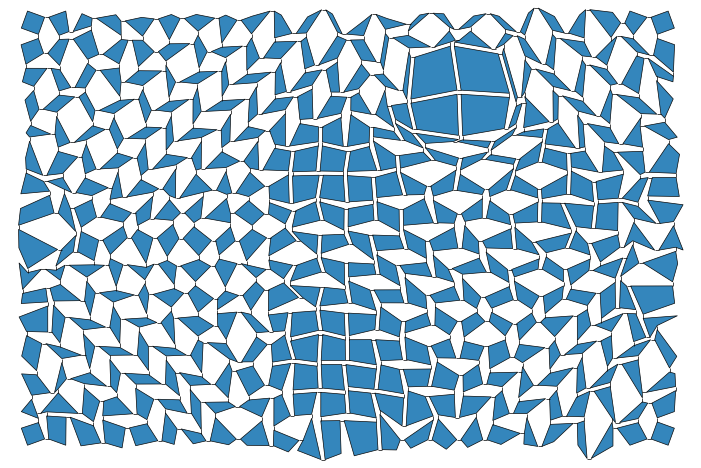

In [5]:
# Best design
plot_design(
    optimization,
    optimization_filename=optimization_filename,
    iteration=-1,
    figsize=(7, 7*(optimization.forward_problems[0].n2_blocks)/optimization.forward_problems[0].n1_blocks),
    fontsize=14,
    grid=False,
    axis=False,
)


### Animation

In [ ]:
generate_response_animations(
    optimization=optimization,
    optimization_filename=optimization_filename,
    figsize=(7, 7*(optimization.forward_problems[0].n2_blocks) /
             optimization.forward_problems[0].n1_blocks),
    dpi=300,
    fps=30,
    cmap="inferno",
    legend_label="Velocity [mm/s]",
    fontsize=14,
    grid=False,
    axis=False,
)

### Plot average kinetic energy distribution


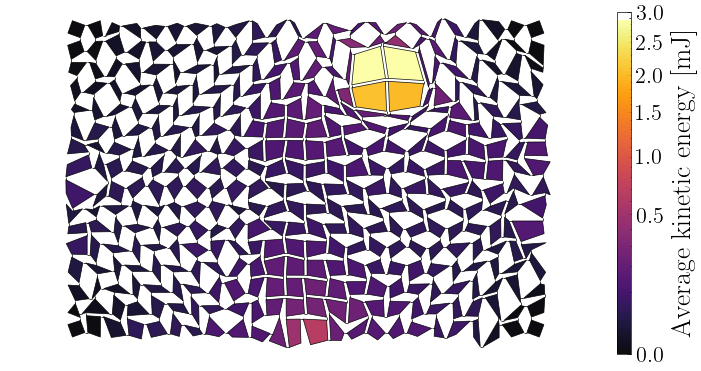

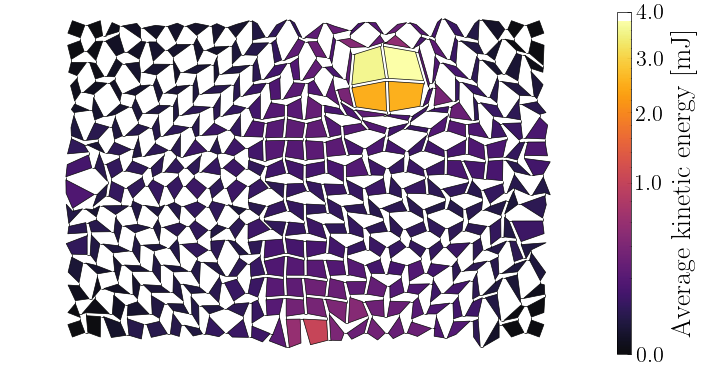

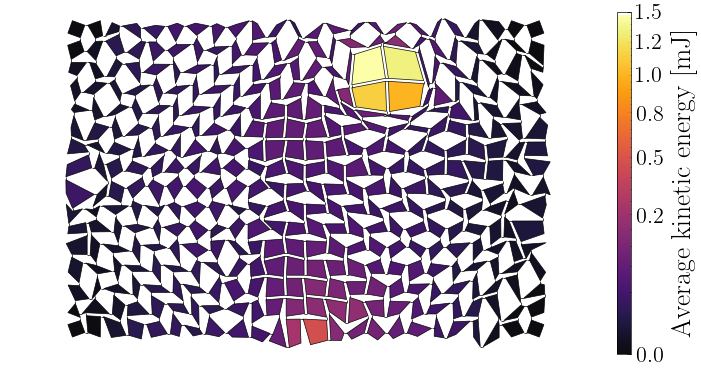

In [6]:
for forward_problem in optimization.forward_problems:
    design_label = f"average_kinetic_energy_loaded_side_{forward_problem.loaded_side}"
    fig, axes = plot_design(
        optimization=optimization,
        optimization_filename=f"{optimization_filename}",
        design_label=design_label,
        figsize=(7, 3.7),
        field_values=average_kinetic_energy_per_block(
            forward_problem.solution_data,
            compute_inertia(
                vertices=forward_problem.solution_data.centroid_node_vectors,
                density=forward_problem.density,
            )
        ),
        scaling=0.5,
        cmap="inferno",
        cmap_label="Average kinetic energy [mJ]",
        fontsize=20,
        grid=False,
        axis=False,
    )

### Comparison with single input design

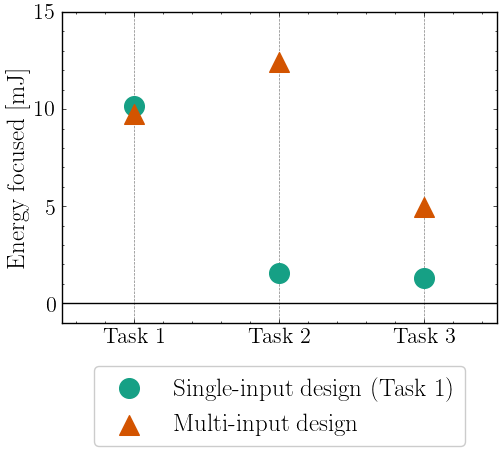

In [7]:
# NOTE: These numbers are hardcoded! They need to be updated if the optimization is rerun.
energy_single = [10.185349453249332,  1.56821394,  1.31437904]
energy_multiple = optimization.objective_values_individual[-1]/optimization.forward_problems[0].n_timepoints
x_labels = ["Task 1", "Task 2", "Task 3"]
fig, axes = plt.subplots(figsize=(5, 4.5), constrained_layout=True)
axes.scatter(x_labels, energy_single, color="#16a085", s=200, marker="o")
axes.scatter(x_labels, energy_multiple, color="#d35400", s=200, marker="^")
axes.tick_params(labelsize=16)
axes.set_ylabel("Energy focused [mJ]", fontsize=18)
axes.grid(axis="y")
axes.set_ylim(-1, 15)
axes.set_xlim(-0.5, 2.5)
axes.axhline(0, color="black", linewidth=1)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
# Place legend below the plot
axes.legend(["Single-input design (Task 1)", "Multi-input design"],
            loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize=18)
fig.savefig(
    f"../out/{optimization.name}/{optimization_filename}/energy_focused_comparison_multi_vs_single.png",
    dpi=300,
)